1.Kết nối google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2.Khai báo thư viện:

In [2]:
# Thư viện dùng để đọc dữ liệu từ tệp csv
import pandas as pd
#Thư viện vẽ biểu đồ
import matplotlib as plt
import seaborn as sb
from matplotlib import pyplot as plt
#Thư viện dùng để chia tập dữ liệu
from sklearn.model_selection import train_test_split
# Thư viện dùng để tiền xử lý dữ liệu
from sklearn.preprocessing import LabelEncoder
#Thư viện dùng kiểm thử mô hình
from sklearn.metrics import r2_score 
#Thư viện xây dựng mô hình hồi quy tuyến tính
from sklearn.linear_model import LinearRegression

3.Triển khai đọc dữ liệu từ google drive

In [5]:
data=pd.read_csv('/content/drive/MyDrive/LaptopPricePrediction/laptops.csv',encoding='latin-1')
#Kiểm tra thử dữ liệu
data.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


4.Xử lí dữ liệu thô:

In [6]:
#Xử lí cột Product:
data['Product'] = data['Product'].str.split('(').apply(lambda x: x[0])

In [7]:
#Xử lí cột CPU
#Chia phần Cpu thành 3 thuộc tính nữa là : Speed, Vender, Type
#Speed CPU sẽ ở phía cuối: xGhz
data['Cpu_Speed'] = data['Cpu'].str.split(' ').apply(lambda x: x[-1]).str.replace('GHz', '')
data['Cpu_Speed'] = data['Cpu_Speed'].astype('float')
#Vender là nhà sản xuất: sẽ ở phần đầu:
data['Cpu_Vender'] = data['Cpu'].str.split(' ').apply(lambda x: x[0])
#Type sẽ lấy ở phần giữa, sau khi xử lí sẽ ở dạng list.
data['Cpu_Type'] = data['Cpu'].str.split(' ').apply(lambda x: x[1:-1])
#Chuyển list thành chuỗi
data['Cpu_Type'] = data['Cpu_Type'].apply(lambda x: ' '.join(x))


In [8]:
#Xử lí Gpu
#Chia Gpu thành Gpu vender vs Gpu type
data['Gpu_vender']=data['Gpu'].str.split(' ').apply(lambda x: x[0])
data['Gpu_Type'] = data['Gpu'].str.split(' ').apply(lambda x: x[1:])
data['Gpu_Type']=data['Gpu_Type'].apply(lambda x: ' '.join(x))


In [9]:
#Xử lí cột Ram
data['Ram']=data['Ram'].str.replace('GB','')
data['Ram'] = data['Ram'].astype('int')
#Xử lí cột Weight
data['Weight'] = data['Weight'].str.replace('kg', '')
data['Weight'] = data['Weight'].astype('float')
# Xem màn hình có công nghệ ips hay touchscreen không, có=1, không =0
data['Touchscreen'] = data['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
data['Ips'] = data['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)


In [10]:
#Xử lí hệ điều hành đưa về mac, window và phần còn lại
def hedieuhanh(x):
  if x == 'macOS' or x=='Mac OS X':
    return 'Mac'
  elif x== 'Windows 10' or x=='Windows 10 S' or x=='Windows 7':
    return 'Windows'
  else:
    return 'Others/No OS/Linux'
data['OpSys'] = data['OpSys'].apply(hedieuhanh)

In [11]:
#Sắp xếp và loại đi những cột thừa
data = data.reindex(columns=['Company','Product', 'TypeName', 'Inches', 'Touchscreen','ScreenResolution', 'Ips',
'Cpu_Vender', 'Cpu_Type','Cpu_Speed','Ram', 'Memory', 'Gpu_vender', 'Gpu_Type', 'Weight', 'OpSys', 'Price_euros' ])

5.Mô tả dữ liệu sau khi đã xử lí:

In [12]:
#Kiểm tra kiểu dữ liệu của các cột sau ghi đã xử lý:
data.dtypes

Company              object
Product              object
TypeName             object
Inches              float64
Touchscreen           int64
ScreenResolution     object
Ips                   int64
Cpu_Vender           object
Cpu_Type             object
Cpu_Speed           float64
Ram                   int64
Memory               object
Gpu_vender           object
Gpu_Type             object
Weight              float64
OpSys                object
Price_euros         float64
dtype: object

In [13]:
#Thuộc tính của tập dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   Touchscreen       1303 non-null   int64  
 5   ScreenResolution  1303 non-null   object 
 6   Ips               1303 non-null   int64  
 7   Cpu_Vender        1303 non-null   object 
 8   Cpu_Type          1303 non-null   object 
 9   Cpu_Speed         1303 non-null   float64
 10  Ram               1303 non-null   int64  
 11  Memory            1303 non-null   object 
 12  Gpu_vender        1303 non-null   object 
 13  Gpu_Type          1303 non-null   object 
 14  Weight            1303 non-null   float64
 15  OpSys             1303 non-null   object 
 16  Price_euros       1303 non-null   float64


In [14]:
# Hiển thị số lượng thuộc tính bị trống
data.isnull().sum()

Company             0
Product             0
TypeName            0
Inches              0
Touchscreen         0
ScreenResolution    0
Ips                 0
Cpu_Vender          0
Cpu_Type            0
Cpu_Speed           0
Ram                 0
Memory              0
Gpu_vender          0
Gpu_Type            0
Weight              0
OpSys               0
Price_euros         0
dtype: int64

In [15]:
#Dữ liệu hoàn chỉnh để phân tích
data.head()

,Company,Product,TypeName,Inches,Touchscreen,ScreenResolution,Ips,Cpu_Vender,Cpu_Type,Cpu_Speed,Ram,Memory,Gpu_vender,Gpu_Type,Weight,OpSys,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,0,IPS Panel Retina Display 2560x1600,1,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,1.37,Mac,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,0,1440x900,0,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,1.34,Mac,898.94
2,HP,250 G6,Notebook,15.6,0,Full HD 1920x1080,0,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,1.86,Others/No OS/Linux,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,0,IPS Panel Retina Display 2880x1800,1,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,1.83,Mac,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,0,IPS Panel Retina Display 2560x1600,1,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,1.37,Mac,1803.60


6.Mã hóa các biến và tiến hành train test tập dữ liệu:

In [16]:
# Mã hóa các thuộc tính từ dạng định danh (object) về dạng số, kể cả dạng classification(0 và 1)
lb_make = LabelEncoder()
data['Company'] = lb_make.fit_transform(data['Company'])
data['TypeName'] = lb_make.fit_transform(data['TypeName'])
data['Touchscreen'] = lb_make.fit_transform(data['Touchscreen'])
data['Ips'] = lb_make.fit_transform(data['Ips'])
data['Cpu_Vender'] = lb_make.fit_transform(data['Cpu_Vender'])
data['Cpu_Type'] = lb_make.fit_transform(data['Cpu_Type'])
data['Memory'] = lb_make.fit_transform(data['Memory'])
data['Gpu_vender'] = lb_make.fit_transform(data['Gpu_vender'])
data['Gpu_Type'] = lb_make.fit_transform(data['Gpu_Type'])
data['OpSys'] = lb_make.fit_transform(data['OpSys'])
data['Product'] = lb_make.fit_transform(data['Product'])
data['ScreenResolution'] = lb_make.fit_transform(data['ScreenResolution'])
features=['Company','Product','TypeName','Inches','ScreenResolution','Touchscreen','Ips','Cpu_Vender','Cpu_Type','Cpu_Speed','Ram'
,'Memory','Gpu_vender','Gpu_Type','Weight','OpSys']
target=['Price_euros']
X = data[features]
Y = data[target]
# Chia bộ dữ liệu thành hai tập: train & test (theo tỉ lệ 60% & 40%)
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.4, random_state=110)


In [17]:
#Xây dựng mô hình LinearRegression
model = LinearRegression()
# Đưa dữ liệu vào huấn luyện mô hình
model.fit(X_train,Y_train)
# Kiểm thử mô hình trên tập test
Y_pred = model.predict(X_test)
print ('Độ chính xác của mô hình: ', r2_score(Y_pred,Y_test)*100,'%')

Độ chính xác của mô hình:  63.40943245437538 %


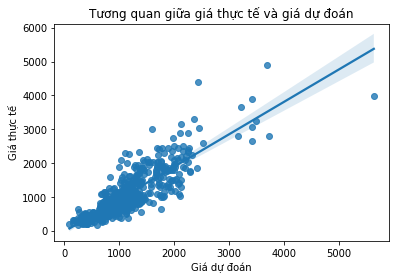

In [18]:
#Vẽ đồ thị tương quan giữa giá dự đoán và giá thực tế:
def vedothi():
  sb.regplot(x=Y_pred,y=Y_test)
  plt.xlabel ('Giá dự đoán')
  plt.ylabel ('Giá thực tế')
  plt.title('Tương quan giữa giá thực tế và giá dự đoán')
vedothi()

7.Tiến hành dự đoán giá:

In [19]:
'''Dự đoán giá laptop gồm thông tin:
Company:Asus => 2
Product: X553SA-XX031T => 543
TypeName:Notebook => 3
Inches:15.6=> 15.6
Touchscreen:0=> 0
ScreenResolution  1366x768 => 0
Ips:0=> 0
Cpu_Vender:Intel =>1
Cpu_Type:Celeron Dual Core N3050 =>20
Cpu_Speed 1.6=> 1.6
Ram:4 =>4
Memory:500GB SSD => 26 	
Gpu_vender: Intel	=> 2
Gpu_Type:HD Graphics=> 42
Weight:2.2 =>2.2
OpSys:Windows =>2
Price_euros:369
'''
mylaptop=[[2,543,3,15.6,0,0,0,1,20,1.6,4,26,2,42,2.2,2]]
price_predict=model.predict(mylaptop)
print ("Giá bán laptop dự đoán là: ",price_predict)

Giá bán laptop dự đoán là:  [[373.87746133]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
